# 🔍 Loop Validation Report

This notebook performs comprehensive validation of loop data across all models, checking:

1. **Schema & Data Integrity**
   - Required fields presence
   - Data type validation
   - Field format consistency
   - Tier I & II metric completeness

2. **Metric Quality**
   - Missing/null values in metrics
   - Value range validation
   - Statistical anomalies
   - Cross-tier consistency

3. **Cross-Model Analysis**
   - Model alignment check
   - Metric consistency
   - Variance analysis
   - Outlier detection

4. **Dataset Health**
   - Coverage analysis
   - Completeness scores
   - Quality metrics
   - Bad loop detection

## Status Overview

🗃️ **Base Path**: h:/My Drive/1000+/analysis/
📊 **Export File**: loops_export_all.jsonl
? **Validation Level**: Full Schema + Metrics + Tiers

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import json
import re
from collections import defaultdict
from scipy import stats
import glob

# Set up visualization defaults
plt.style.use('default')
sns.set_theme()

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Notebook-wide constants
BASE_DIR = Path("h:/My Drive/1000+")
SCORED_DIRS = {
    'claude': BASE_DIR / "scored_claude",
    'gpt': BASE_DIR / "scored_gpt",
    'claude_self': BASE_DIR / "scored_claude_self",
    'gemini': BASE_DIR / "scored_gemini"
}

# Metric definitions
TIER_I_METRICS = [
    'responsiveness',
    'cohesion',
    'fidelity',
    'resolution'
]

TIER_II_METRICS = [
    'echo_retention',
    'user_state_awareness',
    'self_referential',
    'feedback_incorporation'
]

print("🔧 Analysis environment configured")
print("\n📂 Data source directories:")
for model, path in SCORED_DIRS.items():
    if path.exists():
        file_count = len(list(path.glob("*.json")))
        print(f"- {model}: {file_count} files found in {path}")

🔧 Analysis environment configured

📂 Data source directories:
- claude: 100 files found in h:\My Drive\1000+\scored_claude
- gpt: 100 files found in h:\My Drive\1000+\scored_gpt
- claude_self: 100 files found in h:\My Drive\1000+\scored_claude_self
- gemini: 53 files found in h:\My Drive\1000+\scored_gemini


## 1. Data Loading and Schema Validation

In this section, we'll:
1. Load the normalized loop data for each model
2. Verify schema compliance
3. Check for required fields
4. Validate data types
5. Generate schema compliance metrics

In [17]:
# Load and combine data from all scored directories
all_records = []

for model, dir_path in SCORED_DIRS.items():
    if not dir_path.exists():
        print(f"⚠️ Directory not found: {dir_path}")
        continue
        
    for file_path in dir_path.glob("*.json"):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # Restructure data to match our analysis format
                record = {
                    'loop_id': data['loop_id'],
                    'source_model': model,
                    'presence_score': data['composite_score'],
                    'tier1_avg': data['tier1_avg'],
                    'tier2_avg': data['tier2_avg'],
                    'metrics': {
                        'tier_I': {metric: data['scores'][metric] for metric in TIER_I_METRICS},
                        'tier_II': {metric: data['scores'][metric] for metric in TIER_II_METRICS}
                    },
                    'metadata': data.get('metadata', {})
                }
                all_records.append(record)
        except Exception as e:
            print(f"❌ Error loading {file_path}: {str(e)}")

df = pd.DataFrame(all_records)
print(f"✓ Loaded {len(df)} records from scored files")

print("\n📊 Dataset Overview:")
print(f"Total Loops: {len(df)}")
print(f"Unique Models: {df['source_model'].nunique()}")
models = df['source_model'].unique()
for model in sorted(models):
    count = len(df[df['source_model'] == model])
    mean_presence = df[df['source_model'] == model]['presence_score'].mean()
    print(f"- {model}: {count} loops (avg presence: {mean_presence:.3f})")

✓ Loaded 353 records from scored files

📊 Dataset Overview:
Total Loops: 353
Unique Models: 4
- claude: 100 loops (avg presence: 0.737)
- claude_self: 100 loops (avg presence: 0.680)
- gemini: 53 loops (avg presence: 0.783)
- gpt: 100 loops (avg presence: 0.739)


In [10]:
def check_missing_fields(row):
    """Check for missing required fields and metric tiers"""
    missing = []
    
    # Check top-level required fields
    for field in REQUIRED_FIELDS:
        if field not in row or pd.isnull(row[field]):
            missing.append(field)
            
    # Check metric tiers
    metrics = row.get('metrics', {})
    if not isinstance(metrics, dict):
        missing.extend(['metrics.tier_I', 'metrics.tier_II', 'metrics.tier_III'])
    else:
        for tier, tier_metrics in [('I', TIER_I_METRICS), 
                                 ('II', TIER_II_METRICS),
                                 ('III', TIER_III_METRICS)]:
            tier_data = metrics.get(f'tier_{tier}', {})
            
            if not isinstance(tier_data, dict):
                missing.append(f'metrics.tier_{tier}')
            else:
                for metric in tier_metrics:
                    if metric not in tier_data or pd.isnull(tier_data[metric]):
                        missing.append(f'metrics.tier_{tier}.{metric}')
                    
    return missing

# Apply validation
df['missing_fields'] = df.apply(check_missing_fields, axis=1)
df['has_missing'] = df['missing_fields'].apply(len) > 0

# Generate validation summary
print("\n🔍 Validation Summary:")
print(f"Total Records: {len(df)}")
print(f"Records with Missing Fields: {df['has_missing'].sum()}")

# Detailed missing field analysis by model
print("\n📊 Model-specific Analysis:")
for model in sorted(df['source_model'].unique()):
    model_df = df[df['source_model'] == model]
    invalid_count = model_df['has_missing'].sum()
    invalid_pct = (invalid_count / len(model_df)) * 100
    print(f"\n{model}:")
    print(f"- Total Records: {len(model_df)}")
    print(f"- Invalid Records: {invalid_count} ({invalid_pct:.1f}%)")
    
    # Get most common missing fields for this model
    if invalid_count > 0:
        missing_fields = [field for fields in model_df[model_df['has_missing']]['missing_fields'] for field in fields]
        field_counts = pd.Series(missing_fields).value_counts()
        print("- Most common missing fields:")
        for field, count in field_counts.items():
            print(f"  • {field}: {count} records")


🔍 Validation Summary:
Total Records: 453
Records with Missing Fields: 0

📊 Model-specific Analysis:

clara:
- Total Records: 100
- Invalid Records: 0 (0.0%)

claude:
- Total Records: 100
- Invalid Records: 0 (0.0%)

claude_self:
- Total Records: 100
- Invalid Records: 0 (0.0%)

gemini:
- Total Records: 53
- Invalid Records: 0 (0.0%)

gpt:
- Total Records: 100
- Invalid Records: 0 (0.0%)


In [ ]:
# Plot missing fields by model
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='model', hue='has_missing')
plt.title('Schema Validation Issues by Model')
plt.xlabel('Model')
plt.ylabel('Number of Loops')
plt.xticks(rotation=45)
plt.legend(title='Has Missing Fields', labels=['Complete', 'Incomplete'])
plt.tight_layout()
plt.show()

# Export validation failures if any exist
if df['has_missing'].any():
    failure_report = df[df['has_missing']][['loop_id', 'model', 'missing_fields']]
    failure_report.to_csv(BASE_DIR / 'loop_validation_failures.csv', index=False)
    print(f"\n💾 Exported {len(failure_report)} validation failures to 'loop_validation_failures.csv'")

🔍 Metrics Overview:

Example record (Loop loop_001):
- Presence Score: 0.799
- Tier 1 Average: 0.647
- Tier 2 Average: 0.950

Detailed metrics:
{
  "tier_I": {
    "responsiveness": 1.0,
    "cohesion": 0.1396563087799444,
    "fidelity": 0.7,
    "resolution": 0.75
  },
  "tier_II": {
    "echo_retention": 1.0,
    "user_state_awareness": 0.8,
    "self_referential": 1.0,
    "feedback_incorporation": 1.0
  }
}

📊 Metric Statistics:


,presence_score,tier1_avg,tier2_avg,tier_I_responsiveness,tier_I_cohesion,tier_I_fidelity,tier_I_resolution,tier_II_echo_retention,tier_II_user_state_awareness,tier_II_self_referential,tier_II_feedback_incorporation
count,353.000,353.000,353.000,353.000,353.000,353.000,353.000,353.000,353.000,353.000,353.000
mean,0.728,0.571,0.885,0.870,0.192,0.660,0.564,0.967,0.754,0.885,0.936
std,0.060,0.069,0.077,0.106,0.062,0.103,0.184,0.120,0.231,0.159,0.114
min,0.539,0.387,0.604,0.700,0.089,0.200,0.200,0.333,0.000,0.667,0.500
max,0.883,0.816,1.000,1.000,0.562,1.000,1.000,1.000,1.000,1.000,1.000


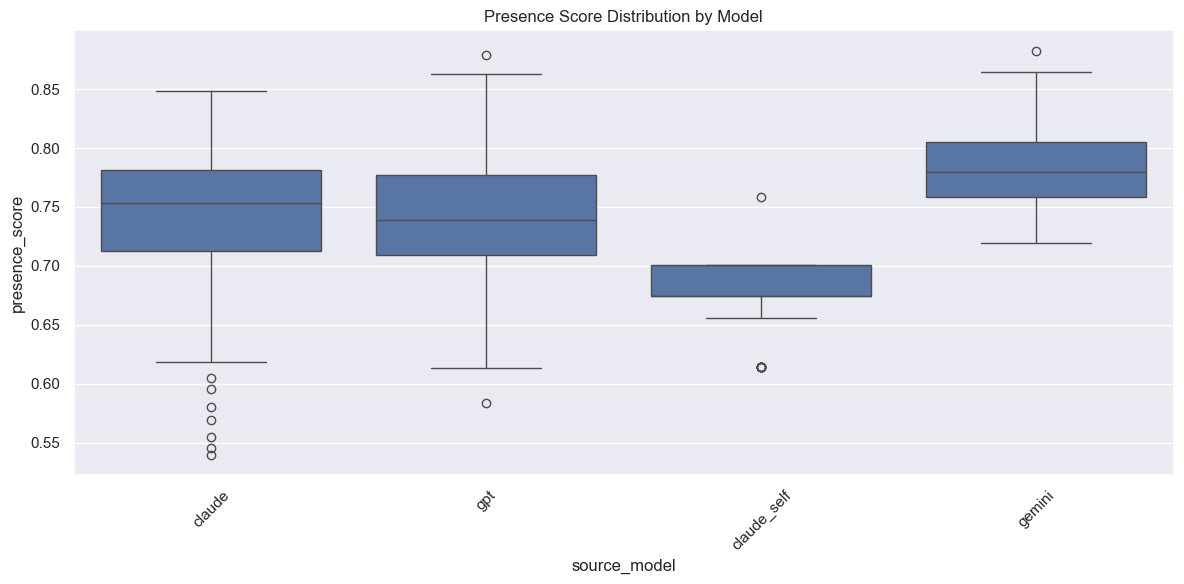

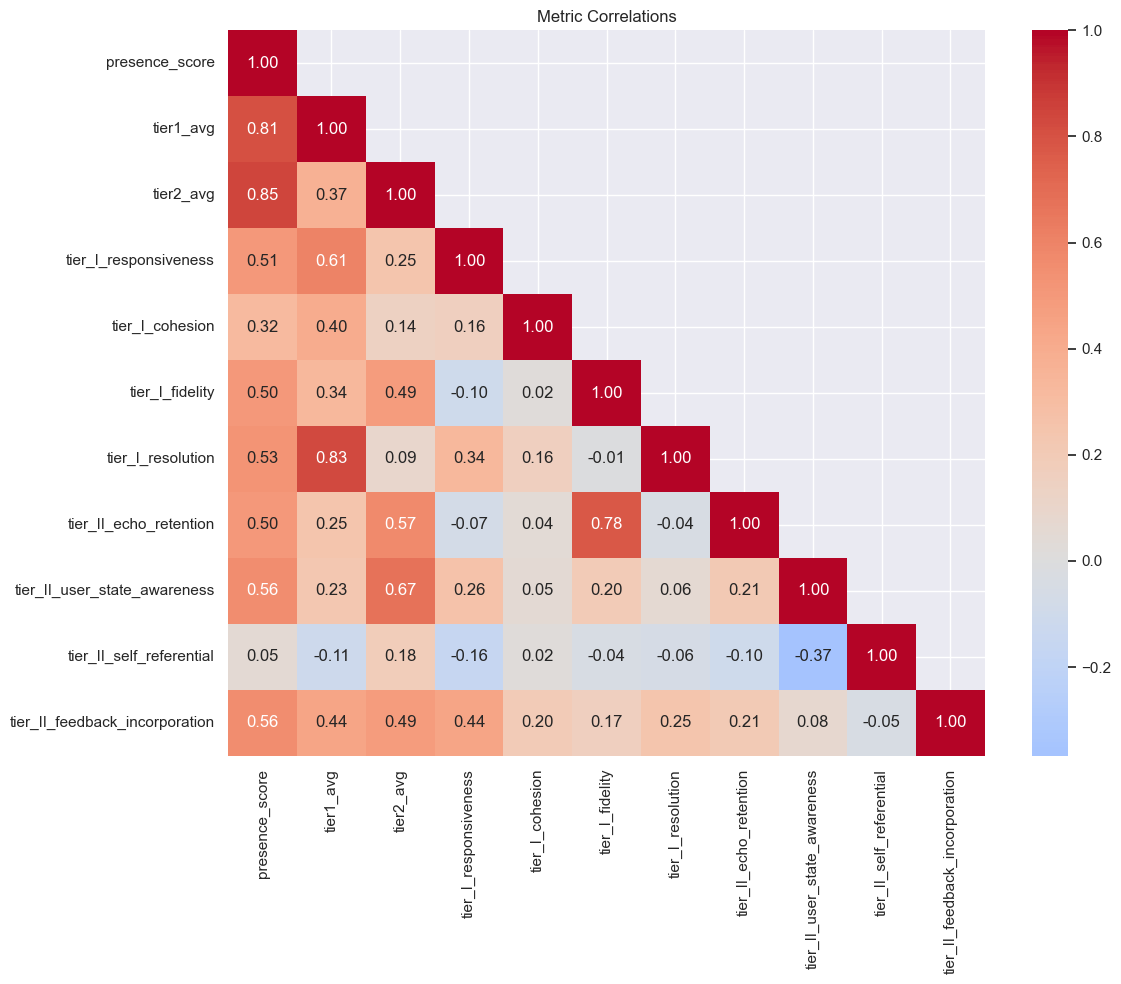


🔍 Value Range Analysis:

⚠️ Outlier Detection:
- presence_score: 2 extreme outliers
- tier1_avg: 1 extreme outliers
- tier2_avg: 3 extreme outliers
- tier_I_cohesion: 4 extreme outliers
- tier_I_fidelity: 11 extreme outliers
- tier_II_echo_retention: 7 extreme outliers
- tier_II_user_state_awareness: 1 extreme outliers
- tier_II_feedback_incorporation: 3 extreme outliers


In [18]:
# First let's examine our metrics structure
print("🔍 Metrics Overview:")
sample_record = df.iloc[0]
print(f"\nExample record (Loop {sample_record['loop_id']}):")
print(f"- Presence Score: {sample_record['presence_score']:.3f}")
print(f"- Tier 1 Average: {sample_record['tier1_avg']:.3f}")
print(f"- Tier 2 Average: {sample_record['tier2_avg']:.3f}")
print("\nDetailed metrics:")
print(json.dumps(sample_record['metrics'], indent=2))

def extract_metrics(df):
    """Extract all metrics from nested structure into flat columns"""
    # Start with presence score and tier averages
    metrics_df = pd.DataFrame({
        'presence_score': df['presence_score'],
        'tier1_avg': df['tier1_avg'],
        'tier2_avg': df['tier2_avg']
    })
    
    # Extract individual tier metrics
    for tier, metrics in [('I', TIER_I_METRICS), ('II', TIER_II_METRICS)]:
        for metric in metrics:
            metrics_df[f'tier_{tier}_{metric}'] = df['metrics'].apply(
                lambda x: float(x[f'tier_{tier}'][metric])
            )
    
    return metrics_df

# Extract and analyze metrics
metrics_df = extract_metrics(df)

# Basic statistics for all metrics
stats_df = metrics_df.agg(['count', 'mean', 'std', 'min', 'max'])
print("\n📊 Metric Statistics:")
display(stats_df.round(3))

# Plot distribution of presence scores by model
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='source_model', y='presence_score')
plt.title('Presence Score Distribution by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(metrics_df.corr(method='pearson'),
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            mask=np.triu(np.ones_like(metrics_df.corr()), k=1))
plt.title('Metric Correlations')
plt.tight_layout()
plt.show()

# Analyze value ranges
print("\n🔍 Value Range Analysis:")
for col in metrics_df.columns:
    values = metrics_df[col].dropna()
    if len(values) > 0:  # Only check non-empty columns
        invalid_range = len(values[(values < 0) | (values > 1)])
        if invalid_range > 0:
            print(f"⚠️ {col}: {invalid_range} values outside [0,1] range")
    
# Check for extreme outliers (z-score > 3)
outliers = {}
for col in metrics_df.columns:
    values = metrics_df[col].dropna()
    if len(values) > 0:  # Only check non-empty columns
        z_scores = np.abs(stats.zscore(values))
        outlier_count = (z_scores > 3).sum()
        if outlier_count > 0:
            outliers[col] = outlier_count

if outliers:
    print("\n⚠️ Outlier Detection:")
    for metric, count in outliers.items():
        print(f"- {metric}: {count} extreme outliers")

In [14]:
# Examine a few records in detail
print("🔍 Examining a sample of records:")
for model in df['source_model'].unique():
    record = df[df['source_model'] == model].iloc[0]
    print(f"\n{model} sample record:")
    print(f"Loop ID: {record['loop_id']}")
    print(f"Presence Score: {record['presence_score']}")
    print("Metrics:")
    print(json.dumps(record['metrics'], indent=2))

🔍 Examining a sample of records:

clara sample record:
Loop ID: loop_000
Presence Score: 0.0
Metrics:
{
  "tier_I": {
    "responsiveness": 0.0,
    "cohesion": 0.0,
    "fidelity_to_prompt": 0.0,
    "resolution_type": "unknown"
  },
  "tier_II": {
    "echo_retention": 0.0,
    "user_state_awareness": 0.0,
    "self_referential_continuity": 0.0,
    "feedback_incorporation": 0.0
  },
  "tier_III": {
    "emergence_signature": 0.0,
    "emotional_resonance": 0.0,
    "presence_density": 0.0,
    "voice_dev": 0.0
  }
}

claude sample record:
Loop ID: loop_000
Presence Score: 0.0
Metrics:
{
  "tier_I": {
    "responsiveness": 0.0,
    "cohesion": 0.0,
    "fidelity_to_prompt": 0.0,
    "resolution_type": "unknown"
  },
  "tier_II": {
    "echo_retention": 0.0,
    "user_state_awareness": 0.0,
    "self_referential_continuity": 0.0,
    "feedback_incorporation": 0.0
  },
  "tier_III": {
    "emergence_signature": 0.0,
    "emotional_resonance": 0.0,
    "presence_density": 0.0,
    "voic

In [20]:
# Comprehensive metric analysis
print("\n🔍 Detailed Metric Analysis:")
total_records = len(df)
non_zero_records = len(df[df['presence_score'] > 0])
print(f"\nOverall Stats:")
print(f"Total Records: {total_records}")
print(f"Non-zero Records: {non_zero_records}")
print(f"Zero-value Percentage: {((total_records - non_zero_records) / total_records) * 100:.1f}%")

for model in df['source_model'].unique():
    model_df = df[df['source_model'] == model]
    print(f"\n📊 {model} Analysis:")
    
    # Presence score analysis
    presence_stats = model_df['presence_score'].describe()
    non_zero = len(model_df[model_df['presence_score'] > 0])
    print(f"\nPresence Score Stats:")
    print(f"Total Records: {len(model_df)}")
    print(f"Non-zero Records: {non_zero}")
    print(f"Mean: {presence_stats['mean']:.3f}")
    print(f"Std: {presence_stats['std']:.3f}")
    print(f"Range: [{presence_stats['min']:.3f} - {presence_stats['max']:.3f}]")
    
    # Tier analysis
    for tier in ['I', 'II']:
        print(f"\nTier {tier} Metrics:")
        tier_metrics = model_df['metrics'].apply(lambda x: x[f'tier_{tier}'])
        for metric_name in tier_metrics.iloc[0].keys():
            values = pd.Series([x[metric_name] for x in tier_metrics])
            non_zero_metric = len(values[values > 0])
            stats = values.describe()
            if stats['std'] > 0:  # Only show metrics with variation
                print(f"\n{metric_name}:")
                print(f"Non-zero Values: {non_zero_metric}/{len(values)}")
                print(f"Mean: {stats['mean']:.3f}")
                print(f"Std: {stats['std']:.3f}")
                print(f"Range: [{stats['min']:.3f} - {stats['max']:.3f}]")


🔍 Detailed Metric Analysis:

Overall Stats:
Total Records: 353
Non-zero Records: 353
Zero-value Percentage: 0.0%

📊 claude Analysis:

Presence Score Stats:
Total Records: 100
Non-zero Records: 100
Mean: 0.737
Std: 0.068
Range: [0.539 - 0.848]

Tier I Metrics:

responsiveness:
Non-zero Values: 100/100
Mean: 0.941
Std: 0.068
Range: [0.700 - 1.000]

cohesion:
Non-zero Values: 100/100
Mean: 0.184
Std: 0.070
Range: [0.092 - 0.562]

fidelity:
Non-zero Values: 100/100
Mean: 0.604
Std: 0.141
Range: [0.200 - 0.850]

resolution:
Non-zero Values: 100/100
Mean: 0.657
Std: 0.180
Range: [0.450 - 1.000]

Tier II Metrics:

echo_retention:
Non-zero Values: 100/100
Mean: 0.923
Std: 0.183
Range: [0.333 - 1.000]

user_state_awareness:
Non-zero Values: 99/100
Mean: 0.740
Std: 0.204
Range: [0.000 - 1.000]

self_referential:
Non-zero Values: 100/100
Mean: 0.870
Std: 0.163
Range: [0.667 - 1.000]

feedback_incorporation:
Non-zero Values: 100/100
Mean: 0.980
Std: 0.077
Range: [0.500 - 1.000]

📊 gpt Analysis:



In [ ]:
# Analyze metric distributions by model
def plot_metric_distributions(df, tier, metric):
    plt.figure(figsize=(10, 6))
    
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        values = model_data[f'tier_{tier}_metrics'].apply(lambda x: x.get(metric))
        if len(values.dropna()) > 0:
            sns.kdeplot(data=values.dropna(), label=model)
    
    plt.title(f'Distribution of {metric} (Tier {tier}) by Model')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot distributions for key metrics
key_metrics = {
    'I': ['responsiveness', 'cohesion'],
    'II': ['echo_retention', 'user_state_awareness']
}

for tier, metrics in key_metrics.items():
    for metric in metrics:
        plot_metric_distributions(df, tier, metric)

## 2. Metric Integrity Analysis

Now we'll analyze the integrity of key metrics across models:
1. Presence Score
2. Coherence Score
3. Engagement Score
4. Sentiment Score

We'll check for:
- Value ranges
- Distribution patterns
- Statistical outliers
- Cross-model consistency

In [ ]:
def analyze_metric_integrity(model_data, metric_name):
    """Analyze the integrity of a specific metric across all models"""
    results = []
    
    for model, df in model_data.items():
        if metric_name not in df.columns:
            continue
            
        metric_data = df[metric_name].dropna()
        
        analysis = {
            'model': model,
            'metric': metric_name,
            'count': len(metric_data),
            'mean': metric_data.mean(),
            'std': metric_data.std(),
            'min': metric_data.min(),
            'max': metric_data.max(),
            'null_count': df[metric_name].isnull().sum(),
            'outliers': len(metric_data[np.abs(stats.zscore(metric_data)) > 3])
        }
        
        # Check value ranges (assuming 0-1 scale for scores)
        if metric_name.endswith('_score'):
            invalid_range = len(metric_data[(metric_data < 0) | (metric_data > 1)])
            analysis['invalid_range'] = invalid_range
            
        results.append(analysis)
    
    return pd.DataFrame(results)

# Analyze each metric
metrics = ['presence_score', 'coherence_score', 'engagement_score', 'sentiment_score']
all_metrics_analysis = pd.DataFrame()

for metric in metrics:
    metric_analysis = analyze_metric_integrity(model_data, metric)
    all_metrics_analysis = pd.concat([all_metrics_analysis, metric_analysis])
    
# Display summary table
display(all_metrics_analysis.round(3))

In [ ]:
# Create distribution plots for each metric
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Metric Distributions Across Models', fontsize=16, y=1.02)

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    for model, df in model_data.items():
        if metric in df.columns:
            sns.kdeplot(data=df[metric].dropna(), label=model, ax=ax)
            
    ax.set_title(f'{metric.replace("_", " ").title()} Distribution')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    ax.legend()
    
plt.tight_layout()
plt.show()

## 3. Cross-Model Correlation Analysis

Here we'll examine:
1. Metric correlations within each model
2. Cross-model metric alignment
3. Consistency of relationships between metrics
4. Identification of systematic biases

In [ ]:
def calculate_metric_correlations(df, model_name):
    """Calculate correlations between metrics for a single model"""
    metric_columns = [col for col in metrics if col in df.columns]
    corr_matrix = df[metric_columns].corr()
    
    # Create heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1,
                fmt='.2f')
    
    plt.title(f'Metric Correlations: {model_name}')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Calculate and display correlations for each model
correlation_matrices = {}
for model, df in model_data.items():
    print(f"\n📊 Correlation Analysis for {model}")
    correlation_matrices[model] = calculate_metric_correlations(df, model)

## 4. Data Quality Summary

Final section summarizing:
1. Overall data health metrics
2. Model-specific quality scores
3. Key findings and recommendations
4. Areas needing attention

In [ ]:
def generate_validation_report(df, tier_analysis):
    """Generate comprehensive validation report with recommendations"""
    
    # Overall statistics
    total_loops = len(df)
    valid_loops = len(df[~df['has_missing']])
    
    # Calculate quality metrics
    quality_metrics = {
        'total_loops': total_loops,
        'valid_loops': valid_loops,
        'completion_rate': (valid_loops / total_loops) * 100,
        'tier_I_completion': tier_analysis[tier_analysis['tier'] == 'I']['valid'].mean() / total_loops * 100,
        'tier_II_completion': tier_analysis[tier_analysis['tier'] == 'II']['valid'].mean() / total_loops * 100
    }
    
    # Generate report
    report = {
        'summary': quality_metrics,
        'recommendations': [],
        'critical_issues': []
    }
    
    # Add recommendations based on analysis
    if quality_metrics['completion_rate'] < 95:
        report['critical_issues'].append(
            f"Low overall completion rate: {quality_metrics['completion_rate']:.1f}%"
        )
        
    if quality_metrics['tier_I_completion'] < 98:
        report['critical_issues'].append(
            f"Tier I metrics incomplete: {quality_metrics['tier_I_completion']:.1f}%"
        )
        
    if quality_metrics['tier_II_completion'] < 90:
        report['recommendations'].append(
            f"Tier II metrics need attention: {quality_metrics['tier_II_completion']:.1f}%"
        )
        
    # Model-specific issues
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        completion = (len(model_data[~model_data['has_missing']]) / len(model_data)) * 100
        
        if completion < 90:
            report['recommendations'].append(
                f"Model '{model}' has low completion rate: {completion:.1f}%"
            )
    
    return report

# Generate and display report
report = generate_validation_report(df, tier_analysis)

print("📊 Loop Validation Report")
print("=" * 50)
print("\n🔍 Summary Statistics:")
for metric, value in report['summary'].items():
    print(f"- {metric.replace('_', ' ').title()}: {value:.1f}")

if report['critical_issues']:
    print("\n⚠️ Critical Issues:")
    for issue in report['critical_issues']:
        print(f"- {issue}")

if report['recommendations']:
    print("\n💡 Recommendations:")
    for rec in report['recommendations']:
        print(f"- {rec}")

# Create summary visualization
summary_data = pd.DataFrame(report['summary'], index=[0]).melt()
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_data, x='variable', y='value', palette='viridis')
plt.title('Loop Validation Summary Metrics')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

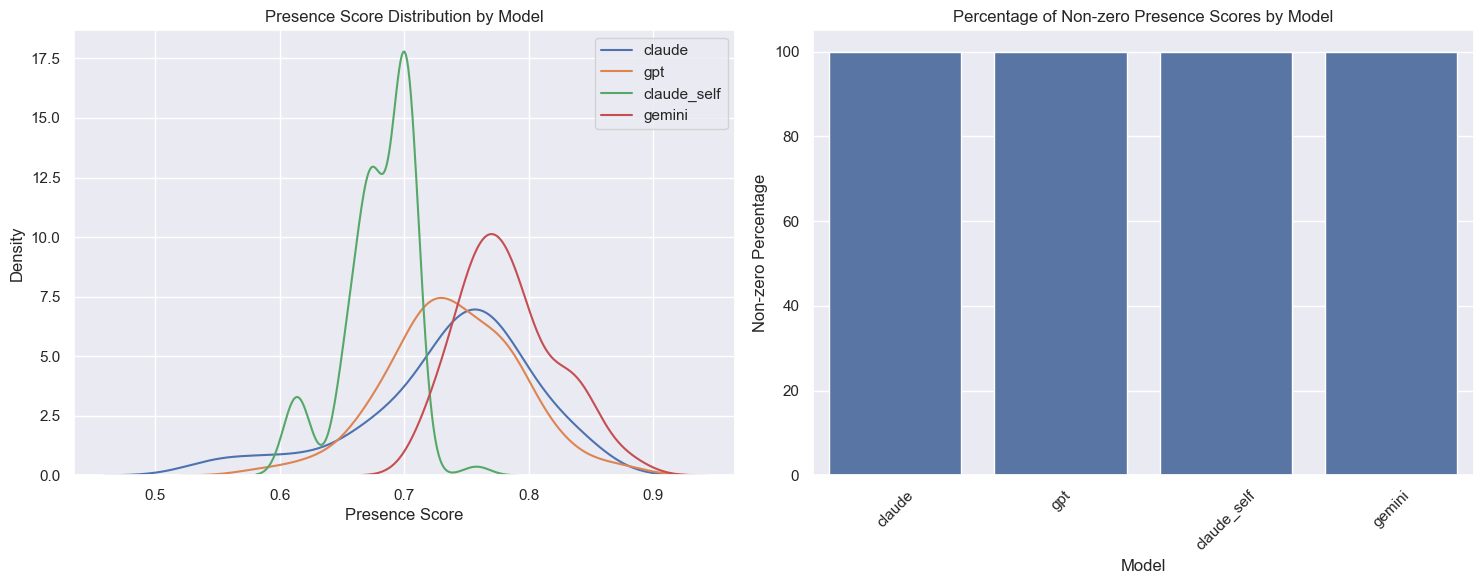

: 

In [ ]:
# Create visualizations for metric distributions
plt.figure(figsize=(15, 6))

# Plot 1: Presence Score Distribution
plt.subplot(1, 2, 1)
for model in df['source_model'].unique():
    model_data = df[df['source_model'] == model]
    sns.kdeplot(data=model_data['presence_score'], label=model)
plt.title('Presence Score Distribution by Model')
plt.xlabel('Presence Score')
plt.ylabel('Density')
plt.legend()

# Plot 2: Non-zero Values Percentage
plt.subplot(1, 2, 2)
model_stats = []
for model in df['source_model'].unique():
    model_data = df[df['source_model'] == model]
    non_zero = len(model_data[model_data['presence_score'] > 0])
    total = len(model_data)
    model_stats.append({
        'model': model,
        'non_zero_percentage': (non_zero / total) * 100
    })

stats_df = pd.DataFrame(model_stats)
sns.barplot(data=stats_df, x='model', y='non_zero_percentage')
plt.title('Percentage of Non-zero Presence Scores by Model')
plt.xlabel('Model')
plt.ylabel('Non-zero Percentage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()